In [ ]:
#https://medium.com/sfu-cspmp/xgboost-a-deep-dive-into-boosting-f06c9c41349
#very good reference

In [24]:
import pandas as pd
import numpy as np

In [25]:
df_master=pd.read_csv("df_master.csv", index_col=0)

In [26]:
df_master.head()

,Date,Open,High,Low,Close*,Adj Close**,Volume,percentage,z-score,Label,...,Gain,Loss,AVG_Gain,AVG_Loss,RS,RSI,obv,VAO,Positive,VolumePositive
0,2008-09-17,11056.58,11057.31,10595.90,10609.66,10609.66,463200000.0,-0.040633,-3.403907,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,-1.004889e+11,False,False
1,2008-09-18,10609.01,11076.44,10459.44,11019.69,11019.69,488060000.0,0.038647,-1.564634,1.0,...,410.03,0.00,NaN,NaN,NaN,NaN,4.880600e+08,1.228691e+11,True,True
2,2008-09-19,11027.51,11483.05,11026.70,11388.44,11388.44,655110000.0,0.033463,0.011810,1.0,...,368.75,0.00,NaN,NaN,NaN,NaN,1.143170e+09,8.749977e+10,True,True
3,2008-09-22,11394.42,11394.58,10992.20,11015.69,11015.69,213210000.0,-0.032731,-1.549244,0.0,...,0.00,372.75,NaN,NaN,NaN,NaN,9.299600e+08,-3.788742e+10,False,False
4,2008-09-23,11015.69,11143.21,10833.94,10854.17,10854.17,204480000.0,-0.014663,-2.108707,0.0,...,0.00,161.52,NaN,NaN,NaN,NaN,7.254800e+08,-2.748313e+10,False,False


In [33]:
df_master.head()
df_master['percentage_yesterday']=df_master['percentage']

In [86]:
# lets first shifting
mask = ~(df_master.columns.isin(['Date','Open', 'High', 'Low', 'Close*', 'Adj Close**', 'percentage', 'Label']))

cols_to_shift = df_master.columns[mask]

df_master[cols_to_shift] = df_master.loc[:,mask].shift(1)


In [87]:
df_master.head() #look at the positive columsn, we are using yesterday's information

,Date,Open,High,Low,Close*,Adj Close**,Volume,percentage,z-score,Label,...,Loss,AVG_Gain,AVG_Loss,RS,RSI,obv,VAO,Positive,VolumePositive,percentage_yesterday
0,2008-09-17,11056.58,11057.31,10595.90,10609.66,10609.66,NaN,-0.040633,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN
1,2008-09-18,10609.01,11076.44,10459.44,11019.69,11019.69,NaN,0.038647,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.040633
2,2008-09-19,11027.51,11483.05,11026.70,11388.44,11388.44,463200000.0,0.033463,-3.403907,1.0,...,NaN,NaN,NaN,NaN,NaN,0.000000e+00,-1.004889e+11,False,False,0.038647
3,2008-09-22,11394.42,11394.58,10992.20,11015.69,11015.69,488060000.0,-0.032731,-1.564634,1.0,...,0.0,NaN,NaN,NaN,NaN,4.880600e+08,1.228691e+11,True,True,0.033463
4,2008-09-23,11015.69,11143.21,10833.94,10854.17,10854.17,655110000.0,-0.014663,0.011810,0.0,...,0.0,NaN,NaN,NaN,NaN,1.143170e+09,8.749977e+10,True,True,-0.032731


# XGBoost Classification

In [88]:
import xgboost as xgb


In [89]:
model=xgb.XGBClassifier()

In [63]:
from sklearn.model_selection import train_test_split


In [90]:
X=df_master[['significance', 'sentiment', '30_SMA', '50_SMA', '200_SMA', 'EMA', 'Upper Bollinger Band', 'Lower Bollinger Band', 'stoch_k', 'stoch_d', 'RSI', 'obv', 'VAO', 'percentage_yesterday']]

In [91]:
y= df_master['percentage'].apply(lambda x: 2 if x > 0 else 1 if x < 0 else 0)
#positive is a 2, 1 is a negative and 0 is o
y

0       1
1       2
2       2
3       1
4       1
       ..
1954    1
1955    2
1956    2
1957    2
1958    2
Name: percentage, Length: 1959, dtype: int64

In [92]:
import seaborn as sns

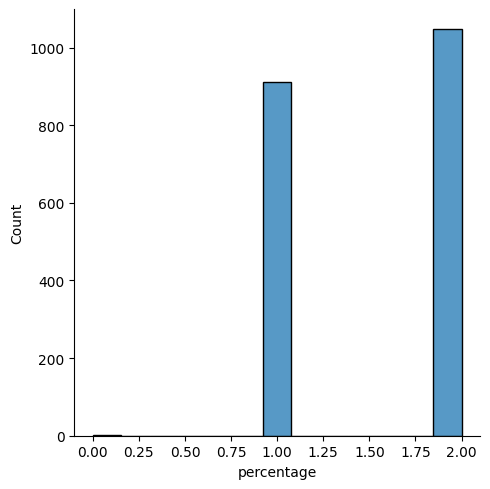

In [93]:
sns.displot(y)

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 2)

In [95]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1371 entries, 1048 to 1192
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   significance          1369 non-null   float64
 1   sentiment             1369 non-null   float64
 2   30_SMA                1369 non-null   float64
 3   50_SMA                1369 non-null   float64
 4   200_SMA               1369 non-null   float64
 5   EMA                   1224 non-null   float64
 6   Upper Bollinger Band  1331 non-null   float64
 7   Lower Bollinger Band  1331 non-null   float64
 8   stoch_k               1224 non-null   float64
 9   stoch_d               1187 non-null   float64
 10  RSI                   1330 non-null   float64
 11  obv                   1369 non-null   float64
 12  VAO                   1369 non-null   float64
 13  percentage_yesterday  1370 non-null   float64
dtypes: float64(14)
memory usage: 160.7 KB


In [96]:
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [97]:
prediction=model.predict(X_test)

In [52]:
from sklearn.metrics import accuracy_score


In [117]:
accuracy_score(y_test, prediction)

ValueError: Length of values (588) does not match length of index (1959)

## Grid Search CV ##

In [100]:
param_grid = {
    "max_depth": [3, 4, 5, 7],
    "learning_rate": [0.1, 0.01, 0.05],
    "gamma": [0, 0.25, 1],
    "reg_lambda": [0, 1, 10],
    "scale_pos_weight": [1, 3, 5],
    "subsample": [0.8],
    "colsample_bytree": [0.5],
}


In [101]:
from sklearn.model_selection import GridSearchCV


In [75]:
# Init classifier
xgb_cl = xgb.XGBClassifier(objective="multi:softmax")



[22:05:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:05:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:05:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:05:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:05:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:05:02] WARNING: /Users/runner/work/xgboost/xgb

/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 471, in _score
    return self._sign * self._score_func(y, y_pred, **scoring_kwargs)
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, *

: { "scale_pos_weight" } are not used.

[22:05:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:05:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:05:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:05:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:05:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:05:07]

nc(y, y_pred, **scoring_kwargs)
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/metrics/_ranking.py", line 619, in roc_auc_score
    raise ValueError("multi_class must be in ('ovo', 'ovr')")
ValueError: multi_class must be in ('ovo', 'ovr')

  warnings.warn(
/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py"

[22:05:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:05:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:05:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:05:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:05:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:05:02] WARNING: /Users/runner/work/xgboost/xgb

/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 471, in _score
    return self._sign * self._score_func(y, y_pred, **scoring_kwargs)
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, *

[22:05:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:05:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:05:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:05:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:05:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:05:01] WARNING: /Users/runner/work/xgboost/xgb

/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 471, in _score
    return self._sign * self._score_func(y, y_pred, **scoring_kwargs)
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, *

[22:05:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:05:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:05:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:05:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:05:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:05:02] WARNING: /Users/runner/work/xgboost/xgb

/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 471, in _score
    return self._sign * self._score_func(y, y_pred, **scoring_kwargs)
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, *

In [76]:
# Init Grid Search
grid_cv = GridSearchCV(xgb_cl, param_grid, n_jobs=-1, cv=3, scoring="roc_auc")


In [77]:
_=grid_cv.fit(X_train, y_train)


/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(
/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 471, in _score
    retur

ValueError: multi_class must be in ('ovo', 'ovr')

  warnings.warn(
/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 471, in _score
    return self._sign * self._score_func(y, y_pred, **scoring_kwargs)
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/utils/

/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 471, in _score
    return self._sign * self._score_func(y, y_pred, **scoring_kwargs)
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, *

/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 452, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/model_selection/_val

/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 471, in _score
    return self._sign * self._score_func(y, y_pred, **scoring_kwargs)
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, *

/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 452, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/model_selection/_val

/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 452, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/model_selection/_val

/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 471, in _score
    return self._sign * self._score_func(y, y_pred, **scoring_kwargs)
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, *

/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:976: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan

[22:11:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:10:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:10:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:10:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:10:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:10:40] WARNING: /Users/runner/work/xgboost/xgb

/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 452, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/model_selection/_val

ner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:10:55] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:10:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:10:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:10:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:10:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp

set to nan. Details: 
Traceback (most recent call last):
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 452, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/louisalu/Documents/04

    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 452, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "

[22:10:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:10:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:10:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:10:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:10:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:10:40] WARNING: /Users/runner/work/xgboost/xgb

/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 471, in _score
    return self._sign * self._score_func(y, y_pred, **scoring_kwargs)
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, *

gboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:11:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:11:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:11:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:11:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:11:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10

pported

  warnings.warn(
/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 471, in _score
    return self._sign * self._score_func(y, y_pred, **scoring_kwargs)
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/utils/_param_validation.py", line 211, in wrappe

[22:10:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:10:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:10:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:10:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:10:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:10:40] WARNING: /Users/runner/work/xgboost/xgb

/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 452, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/model_selection/_val

[22:10:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:10:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:10:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:10:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:10:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:10:40] WARNING: /Users/runner/work/xgboost/xgb

In [62]:
grid_cv.best_score_

nan

In [102]:
y= df_master['percentage'].apply(lambda x: 1 if x >= 0 else 0 )
#positive 1 otherwise 0
y

0       0
1       1
2       1
3       0
4       0
       ..
1954    0
1955    1
1956    1
1957    1
1958    1
Name: percentage, Length: 1959, dtype: int64

In [103]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 2)

In [104]:
xgb_cl = xgb.XGBClassifier(objective="binary:logistic")



In [105]:
grid_cv = GridSearchCV(xgb_cl, param_grid, n_jobs=-1, cv=3, scoring="roc_auc")
_=grid_cv.fit(X_train, y_train)

In [106]:
grid_cv.best_score_

0.5471479021918545

In [107]:
grid_cv.best_params_

{'colsample_bytree': 0.5,
 'gamma': 0.25,
 'learning_rate': 0.1,
 'max_depth': 7,
 'reg_lambda': 0,
 'scale_pos_weight': 3,
 'subsample': 0.8}

In [109]:
param_grid = {
    "max_depth": [5, 7, 9, 11],
    "learning_rate": [0.01, 0.05, 0.07, 0.1],
    "gamma":  [0.25],
    "reg_lambda": [0, 0.2, 0.4],
    "scale_pos_weight": [3],
    "subsample": [0.8],
    "colsample_bytree": [0.5],
}



grid_cv_2 = GridSearchCV(xgb_cl, param_grid, 
                         cv=3, scoring="roc_auc", n_jobs=-1)

_ = grid_cv_2.fit(X_train, y_train)

grid_cv_2.best_score_


0.5471479021918545

In [110]:
grid_cv_2.best_params_

{'colsample_bytree': 0.5,
 'gamma': 0.25,
 'learning_rate': 0.1,
 'max_depth': 7,
 'reg_lambda': 0,
 'scale_pos_weight': 3,
 'subsample': 0.8}

In [111]:
final_cl = xgb.XGBClassifier(
    **grid_cv_2.best_params_,
    objective="binary:logistic",
)


In [112]:
from sklearn.metrics import roc_auc_score


In [113]:
final_cl.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.25, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [114]:
prediction = final_cl.predict(X_test)


In [115]:
roc_auc_score(y_test, prediction)

0.48938723644578314

In [116]:
accuracy_score(y_test, prediction)

0.5289115646258503

In [ ]:
df_